# For Colab only

## Mount Google Drive

In [1]:
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/Colab/fast_style_transfer')
sys.path.append(str(base))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Check available GPU memory

In [2]:
!pip install --quiet gputil
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  | Proc size: 156.9 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# Download COCO dataset

In [3]:
!wget http://images.cocodataset.org/zips/train2014.zip

--2020-01-13 18:00:45--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.40.92
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.40.92|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  35.7MB/s    in 5m 9s   

2020-01-13 18:05:54 (41.7 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [4]:
!7z x train2014.zip

Output hidden; open in https://colab.research.google.com to view.

# Imports

Update fastai library

In [5]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%load_ext autoreload
%autoreload 2

from fastai.vision import ImageList, Image, open_image, Learner, ResizeMethod

import torch
import torch.nn as nn
from torchvision import models

import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

from transformer_net import TransformerNet
from get_vgg import get_vgg_with_hooks

plt.rcParams['figure.facecolor'] = 'white'

<br>

# Create databunch

In [7]:
bs = 16
size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Fastai 'databunch' object includes a dataset and a dataloader

In [8]:
data = (ImageList.from_folder(os.path.join('train2014'))
       .split_none()
       .label_empty()
       .transform(tfms=None, size=size, resize_method=ResizeMethod.CROP)
       .databunch(bs=bs))
data

ImageDataBunch;

Train: LabelList (82783 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: train2014;

Valid: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train2014;

Test: None

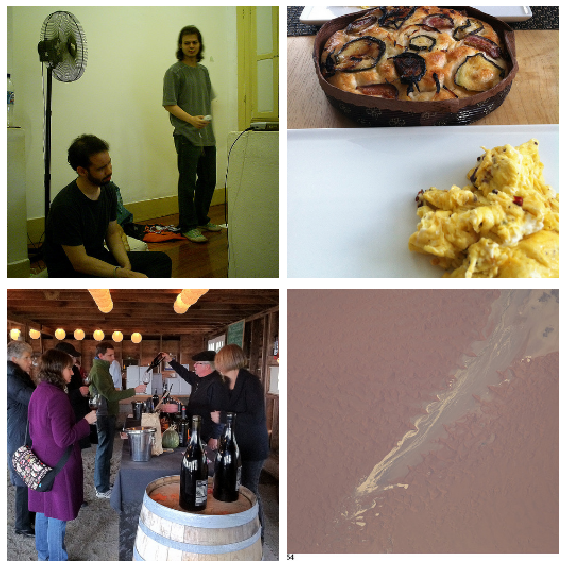

In [9]:
data.show_batch(2)

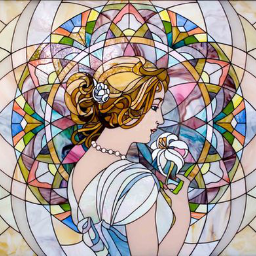

In [10]:
style_img = open_image(os.path.join(base, 'images/style_images/mosaic.jpg'))
style_img = style_img.apply_tfms(tfms=None, size=size, resize_method=ResizeMethod.CROP)
style_img

# Define model architecture

The transformer network defined in a class TransformerNet needs to be wrapped such that both the input image and the transformed image are returned. This way we can use fastai Learner without any modifications. Also, add normalization and denormalization functions before and after the transformer - training is easier and more stable if the input data is normalized.

In [0]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.transformer = TransformerNet()
    
    def forward(self, x):
        y = self.normalize_batch(x)
        y = self.transformer(y)
        y = self.denormalize_batch(y)
        return x, y
    
    @staticmethod
    def normalize_batch(batch):
      # normalize using imagenet mean and std
      mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
      std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
      return (batch - mean) / std
    
    @staticmethod
    def denormalize_batch(batch):
      # normalize using imagenet mean and std
      mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
      std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
      return batch * std + mean

The evaluator returns only transformed image, which is appropriate for evaluating model results.

In [0]:
class Evaluator(nn.Module):
    def __init__(self, transformer_net):
        super().__init__()
        self.transformer = transformer_net
    
    def forward(self, x):
        y = self.normalize_batch(x)
        y = self.transformer(y)
        y = self.denormalize_batch(y)
        return y
    
    @staticmethod
    def normalize_batch(batch):
      # normalize using imagenet mean and std
      mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
      std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
      return (batch - mean) / std
    
    @staticmethod
    def denormalize_batch(batch):
      # normalize using imagenet mean and std
      mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
      std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
      return batch * std + mean

# Define loss function

In [0]:
class VggLoss(nn.Module):
  """
    Calculates style transfer loss function which is a weighted sum of content and style losses
    based on a pretrained VGG network.
  """
  def __init__(self, vgg, style_img, layers, style_weights, content_weights,
               tot_var_weight, bs, device):
    """
      Args:
          vgg - a pretrained backbone of a VGG network; any of the vgg model's features;
                e.g. torchvision.models.vgg19().features.
          style_img - Image object.
          layers - a list a strings of layer names that need a hook, e.g. 'conv_1', 'relu_3'.
          style_weights/content_weights - a list of float or int numbers of equal length as 'layers'.
          bs - int; batch size.
          device - str; typically 'cuda' or 'cpu'.
    """
    super().__init__()
    self.layers = layers
    self.style_weights = style_weights
    self.content_weights = content_weights
    self.tot_var_weight = tot_var_weight
    self.style_img = style_img.data.repeat(bs, 1,1,1).to(device)

    self.vgg, self.hooks = get_vgg_with_hooks(vgg, layers, normalization=True, device=device)
    self.mse = nn.MSELoss().to(device)

    self.vgg(self.style_img)
    self.style_gram = [self.gram_matrix(hook.output) for hook in self.hooks]

  def forward(self, input, _):
    x, y = input

    self.vgg(x)
    features_x = [self.hooks[i].output for i in range(len(self.hooks))]
    self.vgg(y)
    features_y = [self.hooks[i].output for i in range(len(self.hooks))]

    content_loss = sum([self.content_weights[i] * self.mse(features_x[i], features_y[i])
                        for i in range(len(self.hooks))])

    output_gram = [self.gram_matrix(feature) for feature in features_y]
    style_loss = sum([self.style_weights[i] * self.mse(output_gram[i], self.style_gram[i])
                      for i in range(len(self.hooks))])
    
    # total variation loss
    x_var = y[:,:,1:,:] - y[:,:,:-1,:]
    y_var = y[:,:,:,1:] - y[:,:,:,:-1]
    tot_var = self.tot_var_weight * (torch.sum(torch.abs(x_var)) +
                                     torch.sum(torch.abs(y_var)))

    # print(style_loss, content_loss)
    loss = content_loss + style_loss + tot_var
    return loss

  @staticmethod
  def gram_matrix(y):
      (b, ch, h, w) = y.size()
      features = y.view(b, ch, w * h)
      features_t = features.transpose(1, 2)
      gram = features.bmm(features_t) / (ch * h * w)
      return gram

In [0]:
class L2loss(nn.Module):

  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()
  
  def forward(self, input, _):
    x, y = input
    return self.mse(x, y)

# Pretraining

Train the transformer to reconstruct the image. We can use the same loss as for style transfer, but evaluated only on the first layer of vgg model, and with zero style weight.

In [15]:
vgg = models.vgg16(pretrained=True).features.to(device).eval()
for param in vgg.parameters():
  param.requires_grad = False
layers = ['relu_1']
style_weights = [0]
content_weights = [1e05]

loss = VggLoss(vgg, style_img, layers, style_weights, content_weights,
               1e-06, bs, device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:14<00:00, 37.8MB/s]


In [0]:
model = MyModel().to(device)

In [0]:
learner = Learner(data, model, loss_func=loss, wd=1e-06)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


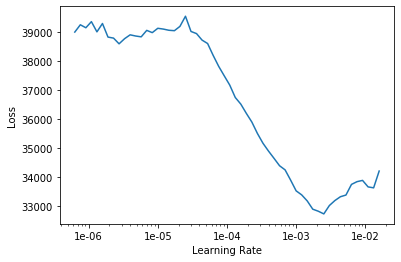

In [19]:
learner.lr_find()
learner.recorder.plot()

In [20]:
learner.fit_one_cycle(1, max_lr=1e-03)

epoch,train_loss,valid_loss,time
0,2747.550293,#na#,32:34


In [0]:
torch.save(model.transformer.state_dict(), os.path.join(base, 'saved_models/pretraining_tv1e-06_wd1e-06_lr1e-03_one_cycle.model'))

Let's see the result

In [0]:
def transform_func(transformer):

  def closure(img):
    with torch.no_grad():
      img = img.data.unsqueeze(0).to(device)
      output = transformer(img)
      output_img = output.squeeze(0).cpu()
    return Image(torch.clamp(output_img, 0.0, 1.0))
  
  return closure

In [0]:
transformer = Evaluator(model.transformer)
evaluate = transform_func(transformer)

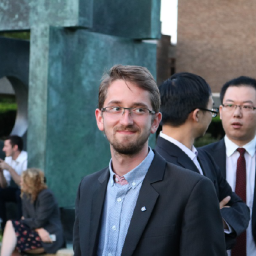

In [24]:
cont_img = open_image(os.path.join(base, 'images/content_images/content.JPG'))
cont_img = cont_img.apply_tfms(tfms=[], size=size, resize_method=ResizeMethod.CROP)
cont_img

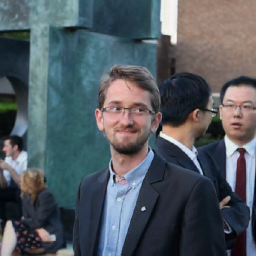

In [25]:
evaluate(cont_img)

For comparison let's do the pretraining with the simpler L2 loss

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


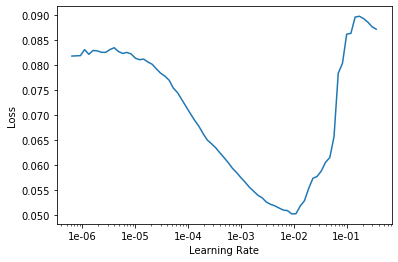

In [26]:
model = MyModel().to(device)
loss = L2loss()
learner = Learner(data, model, loss_func=loss, wd=1e-06)
learner.lr_find()
learner.recorder.plot()

In [27]:
learner.fit_one_cycle(1, max_lr=1e-03)

epoch,train_loss,valid_loss,time
0,0.004896,#na#,29:05


In [0]:
transformer = Evaluator(model.transformer)
evaluate = transform_func(transformer)

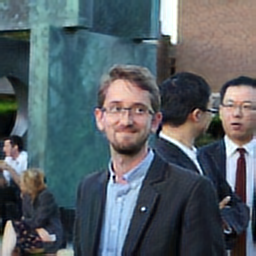

In [29]:
evaluate(cont_img)

It's clearly much more blurred!

# Train style-transfer network

In [30]:
model = MyModel().to(device)
model.transformer.load_state_dict(torch.load(os.path.join(base, 'saved_models/pretraining_tv1e-06_wd1e-06_lr1e-03_one_cycle.model')))

<All keys matched successfully>

In [0]:
vgg = models.vgg16(pretrained=True).features.to(device).eval()
for param in vgg.parameters():
  param.requires_grad = False
layers = ['relu_2', 'relu_4', 'relu_7', 'relu_10']
style_weights = [1e10 * x for x in [1.0, 1.0, 1.0, 1.0]]
content_weights = [1e05 * x for x in [0, 1.0, 0, 0]]

loss = VggLoss(vgg, style_img, layers, style_weights, content_weights,
               1e-06, bs, device)

Since the model was pretrained, we only need a fraction of the data to do the style-transfer training.

In [0]:
data = (ImageList.from_folder(os.path.join('train2014'))[:20000]
       .split_none()
       .label_empty()
       .transform(tfms=None, size=size, resize_method=ResizeMethod.CROP)
       .databunch(bs=bs))

In [0]:
learner = Learner(data, model, loss_func=loss, wd=1e-06)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


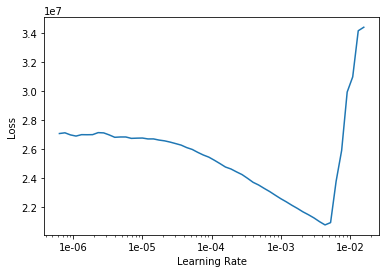

In [36]:
learner.lr_find()
learner.recorder.plot()

In [37]:
learner.fit(1, 2e-04)

epoch,train_loss,valid_loss,time
0,2554973.250000,#na#,11:03


In [40]:
learner.fit_one_cycle(1, 2e-04)

epoch,train_loss,valid_loss,time
0,2307253.500000,#na#,11:04


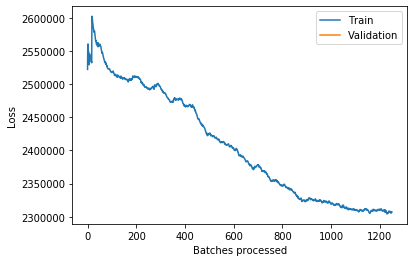

In [41]:
learner.recorder.plot_losses()

# Evaluate

In [0]:
transformer = Evaluator(model.transformer)
evaluate = transform_func(transformer)

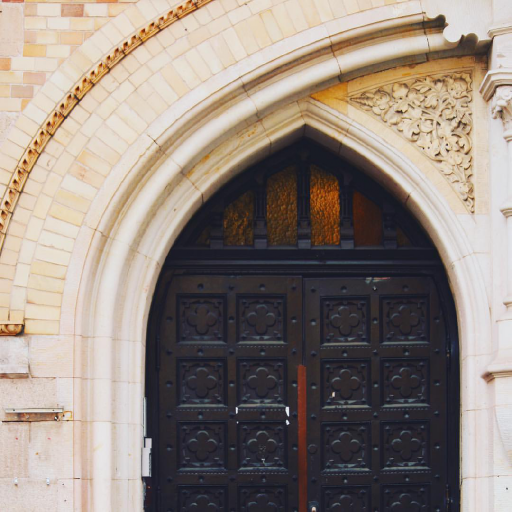

In [49]:
cont_img = open_image(os.path.join(base, 'images/content_images/amber.jpg'))
cont_img = cont_img.apply_tfms(tfms=[], size=size*2, resize_method=ResizeMethod.CROP)
cont_img

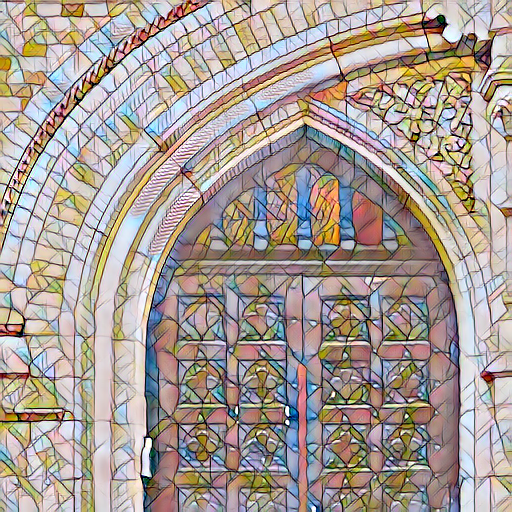

In [50]:
evaluate(cont_img)